# Meter Reader with PaddleOCR
This notebook shows how to create a meter reader with OpenVINO Runtime. We use the pre-trained [PP-OCR](https://github.com/PaddlePaddle/PaddleOCR) to build up a inference task pipeline:

1. Config the screen area of the meter reader.
2. Config the layout information of the meter reader.
3. Pre-process the image based on the given information.
4. Perform OCR recognition.
5. Structure output information.

<img align='center' src= "./WorkFlow_with_ppocr.png" alt="drawing" width="1500"/>

In some cases, the screen area in the image is not in a fixed position. A detection model can be used to dynamically provide the screen area information. Please see [PaddleDetection](https://github.com/PaddlePaddle/PaddleDetection) for more details.

## Imports

In [1]:
!pip install -q "pyclipper>=1.2.1" "shapely>=1.7.1"

In [2]:
import os
import cv2
import numpy as np
import sys
import math
import time
import collections
from PIL import Image
from pathlib import Path
import tarfile
import requests
import matplotlib.pyplot as plt
import copy

from openvino.runtime import Core
from IPython import display
import copy

sys.path.append("../utils")
import notebook_utils as utils
from processing import image_preprocess, post_processing_detection, prep_for_rec, batch_text_box, run_default_models_download, load_default_models, run_ocr_models
import processing as processing

## PaddleOCR with OpenVINO™

[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) is an ultra-light OCR model trained with PaddlePaddle deep learning framework, which aims to create multilingual and practical OCR tools. 

The PaddleOCR pre-trained model used in the demo refers to the *"Chinese and English ultra-lightweight PP-OCR model (9.4M)"*. More open source pre-trained models can be downloaded at [PaddleOCR Github](https://github.com/PaddlePaddle/PaddleOCR) or [PaddleOCR Gitee](https://gitee.com/paddlepaddle/PaddleOCR).

In this notebook, we provide an easy-to-use OCR interface where you can quickly identify text in images with the following codes.

More details for running PaddleOCR with OpenVINO™ are shown in [405-paddle-ocr-webcam](../405-paddle-ocr-webcam/405-paddle-ocr-webcam.ipynb).

### Download and load the OCR models in CPU

In [3]:
# Download models
run_default_models_download()

# Load models
det_compiled_model, det_output_layer, rec_compiled_model, rec_output_layer = load_default_models()

Model already exists
Model already exists


### Run OCR models

[[[1113.0, 111.0], [3093.0, 231.0], [3066.0, 366.0], [1086.0, 246.0]], ('探头：LF-0108:17:50探头主机', 0.7989952)]
[[[1095.0, 258.0], [1965.0, 321.0], [1935.0, 450.0], [1065.0, 387.0]], ('21.5C42.0%RH', 0.90560436)]
[[[1083.0, 483.0], [1857.0, 555.0], [1812.0, 705.0], [1038.0, 636.0]], ('100HZ实时值', 0.88643086)]
[[[1254.0, 660.0], [2937.0, 807.0], [2790.0, 1338.0], [1107.0, 1191.0]], ('213.10', 0.9131314)]
[[[1062.0, 1176.0], [2850.0, 1398.0], [2784.0, 1566.0], [996.0, 1341.0]], ('X:213.02Y:1.40Z:5.48', 0.8683287)]
[[[1086.0, 1437.0], [1254.0, 1437.0], [1254.0, 1512.0], [1086.0, 1512.0]], ('电话', 0.6087779)]
[[[1152.0, 1776.0], [1350.0, 1776.0], [1350.0, 1902.0], [1152.0, 1902.0]], ('F1', 0.99729073)]
[[[1548.0, 1821.0], [1851.0, 1845.0], [1818.0, 1983.0], [1515.0, 1959.0]], ('F2', 0.9906875)]


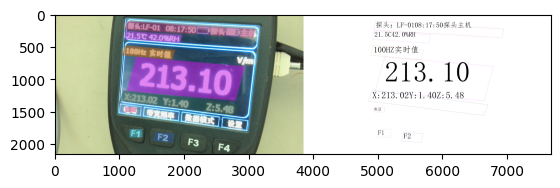

In [3]:
# Read img
img = cv2.imread('Example.jpg')

# Run OCR
results, boxes, txts, scores = run_ocr_models(img, rec_compiled_model, rec_output_layer, det_compiled_model, det_output_layer)

# Print recognition results
for line in results:
    print(line)

# Draw text recognition results beside the image.
image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
draw_img = processing.draw_ocr_box_txt(
    image,
    boxes,
    txts,
    scores,
    drop_score=0.5)
plt.imshow(draw_img)
plt.show()

## Configuration and Pre-processing
Add parameter configuration and make the pre-processing.

### Configuration

Given the area where the reader is in the picture, and config the design size and layout information for the screen.

In [4]:
IMG_PATH = 'Example.jpg'

# The coordinates of the corners of the screen
POINTS = [[1084.5, 64.0],    # Left top
          [3164.5, 160.0],   # right top
          [2978.0, 1791.5],  # right bottom
          [978.5, 1530.5]]   # left bottom

# The size of the screen
DESIGN_SHAPE = (1300, 1000)

# Output template
RESULT_TEMP = {"Info_Probe":"探头:---", 
               "Freq_Set":"", 
               "Freq_Main":"null", 
               "Val_Total":"无探头", 
               "Val_X":"", 
               "Val_Y":"", 
               "Val_Z":"", 
               "Unit":"A/m", 
               "Field":"常规"}

# features and the layout information
DESIGN_LAYOUT = {'Info_Probe':[14, 36, 410, 135],  # feature_name, xmin, ymin, xmax, ymax
                 'Freq_Set':[5, 290, 544, 406], 
                 'Val_Total':[52, 419, 1256, 741], 
                 'Val_X':[19, 774, 433, 882], 
                 'Val_Y':[433, 773, 874, 884], 
                 'Val_Z':[873, 773, 1276, 883], 
                 'Unit':[1064, 291, 1295, 403], 
                 'Field':[5, 913, 243, 998]}

### Pre-processing

Use affine transformations to normalize skewed images

In [5]:
def pre_processing(img, point_list, target_shape):
    # affine transformations
    # point list is the coordinates of the corners of the screen
    # target shape is the design shape
    
    target_w, target_h = target_shape
    pts1 = np.float32(point_list)
    pts2 = np.float32([[0, 0],[target_w,0],[target_w, target_h],[0,target_h]])
    
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img2 = cv2.warpPerspective(img, M, (target_w,target_h))
    return img2

## Post-processing

Post-processing is a very personal step. The image to be recognized may appear blurry, halo, etc., and there may be some errors in the recognition result, which can be corrected through post-processing.

The following code fixes some issues that may exist in the example situation.

In [6]:
def post_processing(results):
    # `LF` can be recognized correctly, but the other may be misidentified
    if 'LF' in results['Info_Probe']: 
        results['Info_Probe'] = "探头:LF-01"
    
    # the target infor is `Frequence`, do not need the suffix `实时值`
    # we will simply delete the words `实时值`
    results['Freq_Set'] = results['Freq_Set'].split('实时值')[0]
    
    # the target infor is values, do not need the prefix
    results['Val_X'] = results['Val_X'].replace("X","").replace(":","") 
    results['Val_Y'] = results['Val_Y'].replace("Y","").replace(":","") 
    results['Val_Z'] = results['Val_Z'].replace("Z","").replace(":","") 
    
    # μ is easy to be recognized as u, and '/' is aesy to be ignored
    if 'T' in results['Unit']: 
        results['Unit'] = "μT"
    elif 'kV' or 'kv' in results['Unit']:
        results['Unit'] = "kV/m"
    elif 'v' or 'V' in results['Unit']:
        results['Unit'] = "V/m"
    else:
        results['Unit'] = "A/m"
        
    return results

## Main Function

In [7]:
# Read img
img = cv2.imread('Example.jpg')

# Pre-processing
img = pre_processing(img, POINTS, DESIGN_SHAPE)

# OCR
## copy the template
struct_result = copy.deepcopy(DESIGN_LAYOUT)

## cut imgs according the layout information
for key in DESIGN_LAYOUT.keys():
    xmin, ymin, xmax, ymax = DESIGN_LAYOUT[key]
    img2 = img[ymin:ymax, xmin:xmax]
    # since the input img is cut, we do not need a detection model to find the position of texts
    result, _, _, _ = run_ocr_models(img2, rec_compiled_model, rec_output_layer, with_det = False)
    try:
        struct_result[key] = result[0][1][0]
    except:
        pass
    
# Post-processing
post_processing(struct_result)

# Print result
print(struct_result)

{'Info_Probe': '探头:LF-01', 'Freq_Set': '100Hz', 'Val_Total': '213.10', 'Val_X': '213.02', 'Val_Y': '1.40', 'Val_Z': '5.48', 'Unit': 'kV/m', 'Field': '电场'}


 ## Try it with your meter photos!
 
 For your own photos, you only need to modify the `Configuration` and `post_processing` to run above!